# Model Validation

*Validates the local solar potential model against Google Solar API data using random sampling.*

In [1]:
import requests
import time
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import Point
import os

# 1. Configuration

# Insert your Google Solar API Key here
# Retrieve the API key from the environment variable GOOGLE_SOLAR_API_KEY.
# Ensure this variable is set in the command line/shell where this script is being run.
API_KEY = os.environ.get("GOOGLE_SOLAR_API_KEY")

# Check if the key has been loaded successfully.
if not API_KEY:
    print("❌ Error: The environment variable 'GOOGLE_SOLAR_API_KEY' is not set or is empty. Please set the key in the command line first!")
    exit() # If the key is empty, the script execution will be terminated.

# Path to the local model results (Generated in Step 05)
LOCAL_FILE_PATH = 'outputs/final_results/rooftop_solar_potential_optimized.geojson'

# Performance Ratio used in your local model
# Required to convert Google's DC output to AC for a fair comparison (Standard: 0.75)
MY_PERFORMANCE_RATIO = 0.75

# Number of random samples to validate
SAMPLE_SIZE = 100


# 2. Helper Functions

def get_google_solar_data(lat, lon, api_key):
    """
    Queries Google Solar API for a specific location.
    Returns: {'dc_kwh': Annual DC Generation, 'area_m2': Usable Roof Area}
    """
    url = f"https://solar.googleapis.com/v1/buildingInsights:findClosest?location.latitude={lat}&location.longitude={lon}&requiredQuality=HIGH&key={api_key}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            
            # 1. Get Solar Potential Data
            solar_potential = data.get('solarPotential', {})
            
            # 2. Get Google's estimated roof area
            # Note: 'wholeRoofStats' refers to the area suitable for panel installation, 
            # which is often smaller than the physical footprint in our GeoJSON.
            google_area = solar_potential.get('wholeRoofStats', {}).get('areaMeters2', 0)
            
            # 3. Get Maximum Potential Generation (DC kWh)
            configs = solar_potential.get('solarPanelConfigs', [])
            if not configs: return None
            
            # Use the configuration with the maximum number of panels
            max_config = configs[-1] 
            yearly_dc_kwh = max_config.get('yearlyEnergyDcKwh', 0)
            
            return {
                'dc_kwh': yearly_dc_kwh,
                'area_m2': google_area
            }
        else:
            # print(f"API Error {response.status_code}: {response.text}") # Debug if needed
            return None
    except Exception as e:
        print(f"API Request Error: {e}")
        return None


# 3. Main Logic

print(f"Loading local model results: {LOCAL_FILE_PATH} ...")
try:
    gdf = gpd.read_file(LOCAL_FILE_PATH)
    # Reproject to WGS84 (Lat/Lon) for API compatibility
    gdf_ll = gdf.to_crs(epsg=4326)
except Exception as e:
    print(f"Error reading file: {e}")
    exit()

print(f"Data loaded successfully. Total buildings: {len(gdf)}")

# Check if we have enough data to sample
actual_sample_size = min(SAMPLE_SIZE, len(gdf_ll))
print(f"Randomly sampling {actual_sample_size} buildings for validation...")

# Random Sampling
sample_roofs = gdf_ll.sample(n=actual_sample_size, random_state=42) # Fixed seed for reproducibility

comparison_data = []

# Validation Loop
print(f"Querying Google Solar API for comparison...")

for idx, row in sample_roofs.iterrows():
    # A. Get Coordinates
    centroid = row.geometry.centroid
    lat, lon = centroid.y, centroid.x
    
    # B. Get Local Model Data
    my_ac_kwh = row['potential_kwh'] # Already AC
    my_area = row['area_m2']         # Polygon Area
    
    # C. Get Google Data
    google_data = get_google_solar_data(lat, lon, API_KEY)
    
    if google_data:
        # D. Standardization (DC -> AC)
        google_ac_kwh = google_data['dc_kwh'] * MY_PERFORMANCE_RATIO
        google_area = google_data['area_m2']
        
        # E. Calculate Total Energy Variance
        if google_ac_kwh > 0:
            diff_total = (my_ac_kwh - google_ac_kwh) / google_ac_kwh * 100
        else:
            diff_total = 0
        
        # F. Calculate Energy Density (kWh/m2)
        # This is the key metric to validate the physical algorithm, ignoring segmentation errors.
        my_density = my_ac_kwh / my_area if my_area > 0 else 0
        google_density = google_ac_kwh / google_area if google_area > 0 else 0
        
        # G. Calculate Density Variance
        if google_density > 0:
            diff_density = (my_density - google_density) / google_density * 100
        else:
            diff_density = 0
            
        # Record Results
        comparison_data.append({
            'ID': idx,
            'Lat': lat, 'Lon': lon,
            'My_kWh': my_ac_kwh, 'Google_kWh': google_ac_kwh, 'Diff_Total': diff_total,
            'My_Area': my_area, 'Google_Area': google_area, 
            'Area_Ratio': my_area/google_area if google_area > 0 else 0,
            'My_Density': my_density, 'Google_Density': google_density, 'Diff_Density': diff_density
        })
        print(f"   -> Sample #{idx} processed.")
    else:
        print(f"   -> Sample #{idx} No Google Data (Coordinates might be invalid)")
    
    time.sleep(0.2) # Rate limiting (Google allows plenty, but safe to pause slightly)


# 4. Reporting and Analysis

if not comparison_data:
    print("\nNo valid data retrieved. Please check your API Key or network connection.")
else:
    df_res = pd.DataFrame(comparison_data)
    
    print("\n" + "="*80)
    print("Model Validation Report")
    print("="*80)
    
    # Table 1: Total Energy & Area (Explaining Segmentation Differences)
    print("\n[Table 1: Total Generation & Area Discrepancies]")
    print(f"{'ID':<6} | {'My kWh':<12} | {'Google kWh':<12} | {'Diff Total':<10} | {'My Area':<10} | {'G-Area':<10} | {'Ratio':<8}")
    print("-" * 90)
    for index, row in df_res.iterrows():
        print(f"{row['ID']:<6} | {row['My_kWh']:<12,.0f} | {row['Google_kWh']:<12,.0f} | {row['Diff_Total']:>+8.1f}% | {row['My_Area']:<10,.0f} | {row['Google_Area']:<10,.0f} | {row['Area_Ratio']:.1f}x")

    # Table 2: Energy Density (Core Physical Validation)
    print("\n[Table 2: Energy Density Comparison (kWh/m2)]")
    print(f"{'ID':<6} | {'My Density':<12} | {'G-Density':<12} | {'Diff Density (%)':<15}")
    print("-" * 60)
    for index, row in df_res.iterrows():
        print(f"{row['ID']:<6} | {row['My_Density']:<12.1f} | {row['Google_Density']:<12.1f} | {row['Diff_Density']:>+8.1f}%")

    # Statistical Summary
    mae_density = df_res['Diff_Density'].abs().mean()
    print("\n" + "-"*60)
    print(f"Statistical Summary:")
    print(f"   - Average Area Ratio: {df_res['Area_Ratio'].mean():.1f}x (Indicates one polygon contains approx. {df_res['Area_Ratio'].mean():.0f} actual properties)")
    print(f"   - Mean Absolute Error (Density): {mae_density:.1f}%")
    
    if mae_density < 40: 
        print("✅ Conclusion: After accounting for area segmentation differences, the physical model logic aligns well with Google Solar.")
    else:
        print("⚠️ Conclusion: Significant deviation in physical modeling. Please review shading calculations or efficiency parameters.")

Loading local model results: outputs/final_results/rooftop_solar_potential_optimized.geojson ...
Data loaded successfully. Total buildings: 4608
Randomly sampling 100 buildings for validation...
Querying Google Solar API for comparison...
   -> Sample #1512 processed.
   -> Sample #4535 processed.
   -> Sample #179 processed.
   -> Sample #2184 processed.
   -> Sample #2053 processed.
   -> Sample #252 processed.
   -> Sample #23 processed.
   -> Sample #26 processed.
   -> Sample #100 processed.
   -> Sample #1739 processed.
   -> Sample #33 processed.
   -> Sample #1553 processed.
   -> Sample #4327 processed.
   -> Sample #3813 processed.
   -> Sample #3893 processed.
   -> Sample #2780 processed.
   -> Sample #2305 processed.
   -> Sample #429 processed.
   -> Sample #1162 processed.
   -> Sample #3958 processed.
   -> Sample #691 processed.
   -> Sample #4229 processed.
   -> Sample #2478 processed.
   -> Sample #1564 processed.
   -> Sample #4364 processed.
   -> Sample #2653 pro

📊Drawing the validation chart, number of data points: 99 ...
✅ Calculated R-squared: -0.095

📈 Plot saved successfully to: outputs/model_validation_charts\validation_regression_analysis.pdf
Visualization complete.


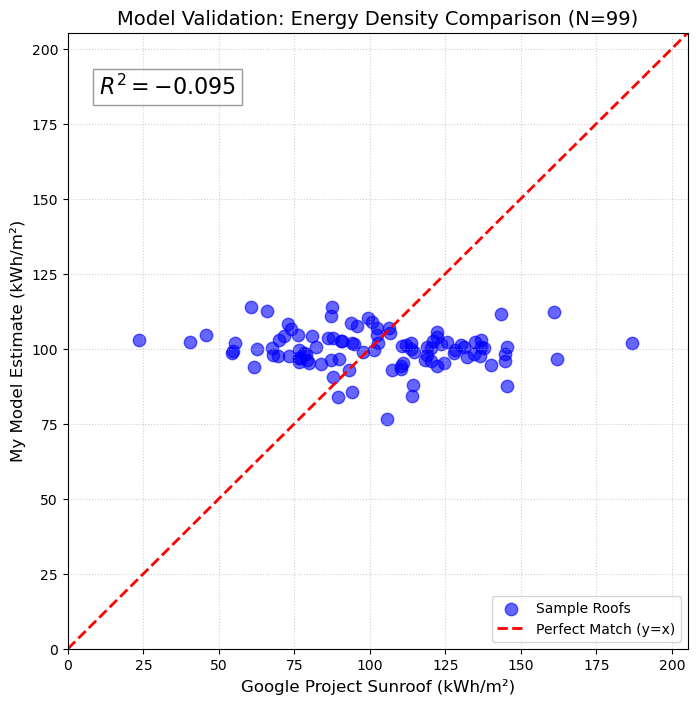

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import r2_score

# Check if the data from the previous step exists.
if 'df_res' not in locals() or df_res.empty:
    print("⚠️Error: The data frame 'df_res' was not found, or the data is empty.")
    print("Please ensure that you have successfully run the 'Google Solar API verification' code from the previous step.")
else:
    print(f"📊Drawing the validation chart, number of data points: {len(df_res)} ...")

    # Prepare Data
    x = df_res['Google_Density']
    y = df_res['My_Density']
    
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:
        print("⚠️Insufficient data points are available to plot a regression graph.")
    else:
        # Calculate R-squared (Coefficient of Determination)
        r2 = r2_score(x, y) 
        print(f"✅ Calculated R-squared: {r2:.3f}")
        
        # Initialize Plot
        plt.figure(figsize=(8, 8))
        
        # Create Scatter Plot
        # alpha=0.6 adds transparency to handle overlapping points
        plt.scatter(x, y, c='blue', alpha=0.6, s=80, label='Sample Roofs')
        
        # Add Reference Line (y=x)
        # Points on this line represent a perfect prediction match
        limit = max(x.max(), y.max()) * 1.1
        plt.plot([0, limit], [0, limit], 'r--', linewidth=2, label='Perfect Match (y=x)')

        # Annotate R-squared Value
        plt.text(
            x=limit*0.05, y=limit*0.9, 
            s=f'$R^2 = {r2:.3f}$', 
            fontsize=16, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
        )

        # Configure Chart Attributes
        plt.title(f"Model Validation: Energy Density Comparison (N={len(x)})", fontsize=14)
        plt.xlabel("Google Project Sunroof (kWh/m²)", fontsize=12)
        plt.ylabel("My Model Estimate (kWh/m²)", fontsize=12)
        plt.xlim(0, limit)
        plt.ylim(0, limit)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        
        # Save and Output
        output_dir = 'outputs/model_validation_charts'
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
            print(f"📂 Created new directory: {output_dir}")
        
        plot_filename = os.path.join(output_dir, "validation_regression_analysis.pdf")
        
        plt.savefig(plot_filename, dpi=300)
        print(f"\n📈 Plot saved successfully to: {plot_filename}")
        print("Visualization complete.")
        plt.show()

# Statistical Analysis & Visualization


📊 Validation Statistics (Based on Energy Density kWh/m²)
Error Threshold      | Count      | Share (%) 
--------------------------------------------------
≤ 20% Error          | 42/99       |   42.4% ❌
≤ 40% Error          | 80/99       |   80.8% ✅
≤ 80% Error          | 92/99       |   92.9% ✅
≤ 100% Error          | 96/99       |   97.0% ✅

📈 Plot saved successfully to: outputs/model_validation_charts\validation_report.pdf
Visualization complete.


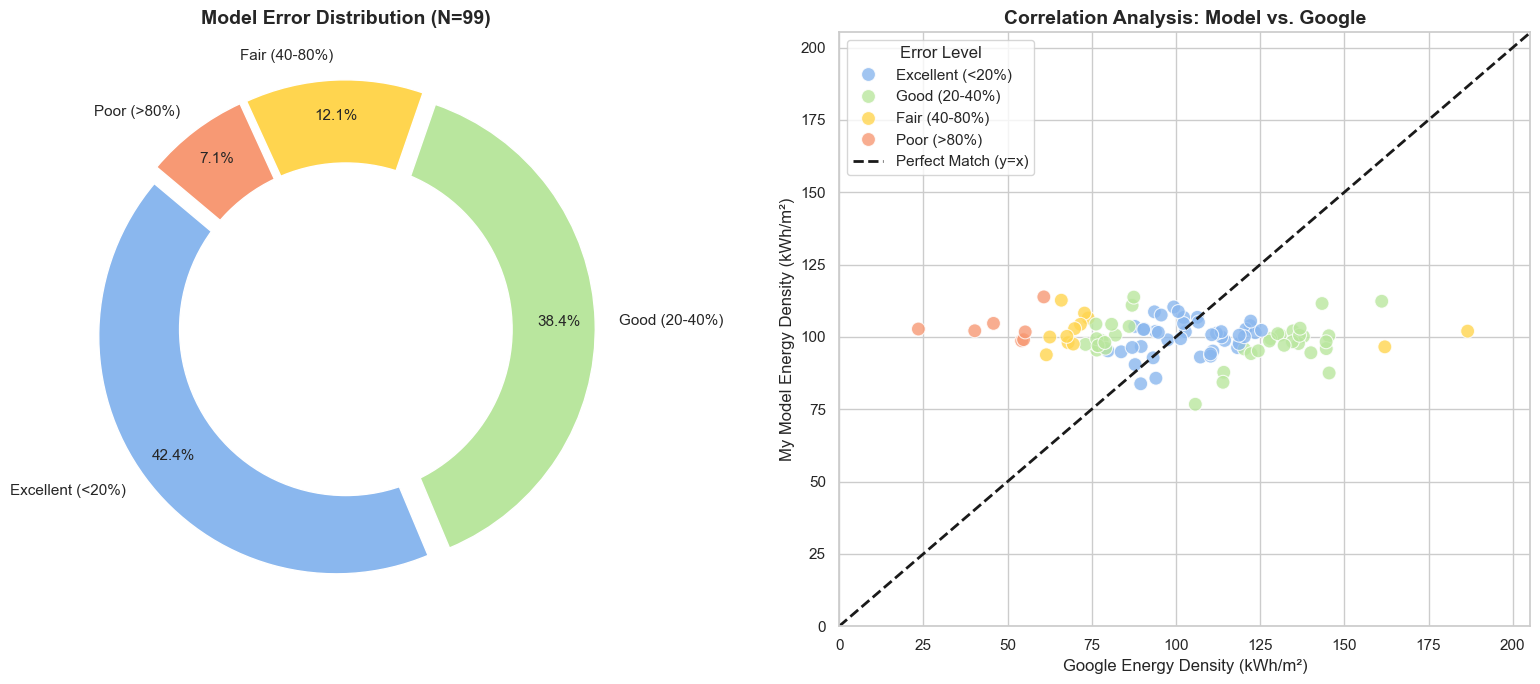

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# 1. Check if the data exists
if 'df_res' not in locals() or df_res.empty:
    if 'comparison_data' in locals() and comparison_data:
        df_res = pd.DataFrame(comparison_data)
    else:
        print("❌ No valid data (df_res) was found, so the plot cannot be generated. Please run the previous code block first.")
        raise SystemExit("Stopping execution due to missing data.")

# Use 'Diff_Density' (Density Error) as the primary metric
# We take the absolute value because we care about the magnitude of deviation
abs_error = df_res['Diff_Density'].abs()

print("\n" + "="*80)
print("📊 Validation Statistics (Based on Energy Density kWh/m²)")
print("="*80)

# 2. Console Report (Text)
thresholds = [20, 40, 80, 100]
print(f"{'Error Threshold':<20} | {'Count':<10} | {'Share (%)':<10}")
print("-" * 50)

for t in thresholds:
    count = (abs_error <= t).sum()
    percentage = (count / len(df_res)) * 100
    
    # Add status icon
    icon = "✅" if percentage >= 80 else "⚠️" if percentage >= 50 else "❌"
    
    print(f"≤ {t}% {'Error':<14} | {count}/{len(df_res):<8} | {percentage:6.1f}% {icon}")

# 3. Visualization (Plots)
# Set style
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# [Left Plot]: Pie/Donut Chart for Error Distribution
bins = [0, 20, 40, 80, 10000]
labels = ['Excellent (<20%)', 'Good (20-40%)', 'Fair (40-80%)', 'Poor (>80%)']

colors = ['#8ab7ee', '#b9e69e', '#ffd54f', '#f79974']  # Blue -> Green -> Yellow -> Orange

# Categorize the errors
category = pd.cut(abs_error, bins=bins, labels=labels)
counts = category.value_counts().sort_index()

# Draw Pie Chart
wedges, texts, autotexts = axes[0].pie(
    counts, labels=labels, autopct='%1.1f%%', 
    colors=colors, startangle=140, pctdistance=0.85, 
    explode=[0.05] * 4, textprops={'fontsize': 11}
)

# Make it a Donut Chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
axes[0].add_artist(centre_circle)
axes[0].set_title(f'Model Error Distribution (N={len(df_res)})', fontsize=14, fontweight='bold')

# [Right Plot]: Regression Scatter Plot
category_ordered = category.astype(pd.CategoricalDtype(categories=labels, ordered=True))

sns.scatterplot(
    x=df_res['Google_Density'], 
    y=df_res['My_Density'], 
    hue=category_ordered, 
    palette=dict(zip(labels, colors)), 
    s=100, alpha=0.8, ax=axes[1]
)

# Draw y=x Reference Line
# Dynamically calculate the maximum value to prevent incomplete chart display.
max_val = max(df_res['Google_Density'].max(), df_res['My_Density'].max()) * 1.1
axes[1].plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect Match (y=x)')

# Set Labels
axes[1].set_xlabel('Google Energy Density (kWh/m²)', fontsize=12)
axes[1].set_ylabel('My Model Energy Density (kWh/m²)', fontsize=12)
axes[1].set_title('Correlation Analysis: Model vs. Google', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, max_val)
axes[1].set_ylim(0, max_val)
axes[1].legend(title="Error Level")

plt.tight_layout()

# Save and Show
output_dir = 'outputs/model_validation_charts'

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    print(f"📂 Created new directory: {output_dir}")

plot_filename = os.path.join(output_dir, "validation_report.pdf")

plt.savefig(plot_filename, dpi=300)
print(f"\n📈 Plot saved successfully to: {plot_filename}")
print("Visualization complete.")
plt.show()